In [ ]:
# encoder decoder fixed, only adjust layer changedå
if lidar_mode == 'sparse':
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/6_channeladjust_sparse_best_model_best_model_600_32_20230522_154333.pth')
)
else:
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/3_dense_best_model_600_32_20230522_072759.pth')
)

In [1]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset_2_encoder import CreateDatasets
from sensorFusionDataset.data_split import split_dataset
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder, TwoEncoderOneDecoder, EncoderFusion, TwoEncoderOneDecoderAfterTraning
from testLoop import test_loop_fusion
from trainLoop import train_loop_fusion
from visualization import plot_losses, plot_metrics,plotTraining
from earlystopping import EarlyStopping

import h5py as h5
from datetime import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import time

local_time =time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[-8:-1]
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
# CPU OR GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

damaged_img_path = 'image_gray_200_damaged' 

lidar_mode = 'sparse'

if lidar_mode == 'sparse':
    lidar_path = 'lidar_tesor_200_sparse'
else:
    lidar_path = 'lidar_tesor_200_dense'

label_path = 'image_gray_200_original'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))[0:7200]
lidar_list = sorted(glob.glob(lidar_path + '/*'))[0:7200]
label_list = sorted(glob.glob(label_path + '/*'))[0:7200]


batch_size = 32
learning_rate = 1e-4
epochs = 600

MyDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)#, img_size=img_size
train_dataset, test_dataset, val_dataset = split_dataset(MyDataset, 0.7, 0.2)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                          drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                         drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
                        drop_last=True)

patience = 50	# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
save_path = 'fusion_model/'
early_stopping = EarlyStopping(save_path = save_path, patience = patience)	

criterion = nn.MSELoss()




# new_model = SimpleAutoencoder()
# new_model.to(device)
# new_model.load_state_dict(torch.load('denoising_model/best_model_300_32_0.0004_20230422_153250.pth'))

# for name, value in new_model.named_parameters():
#     #print (name) # print(model.state_dict().keys())
#     if name.startswith('decoder'):
#         value.requires_grad = False
        
# params = filter(lambda p: p.requires_grad, new_model.parameters())
# optimizer = torch.optim.Adam(params, lr=learning_rate)

# criterion = nn.MSELoss()
# criterion.to(device)

training_loss = []
training_baseloss = []
test_loss = []
testing_baseloss = []
hisLrC = []
min_loss=10000

print (f'loading fertig! {device}' )

loading fertig! cuda


In [ ]:
# retraining with the channel adjust
# loading model
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
if lidar_mode == 'sparse':
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/sparse_FIX_best_model_600_32_20230518_063828.pth'))
else:
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/dense_FIX_best_model_600_32_20230518_154020.pth'))
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
# decoder.load_state_dict(torch.load('denoising_model/best_model_300_32_0.0004_20230422_153250.pth'))
decoder.encoder = removal_layer

channelAdjust = EncoderFusion()
# channelAdjust.to(device)

fusion_net = TwoEncoderOneDecoder(encoder_img, encoder_lidar, decoder, channelAdjust)
fusion_net.to(device)

for name, value in fusion_net.named_parameters():
    # print (name) # print(model.state_dict().keys())
    if name.startswith('decoder'):
        value.requires_grad = False
    if name.startswith('encoder'):
        value.requires_grad = False

params = filter(lambda p: p.requires_grad, fusion_net.parameters())


learning_rate = 0.0004  # 2e-4 batchsize=30
optimizer = torch.optim.Adam(params, lr=learning_rate)

criterion = nn.MSELoss()
criterion.to(device)


start_time = time.time()
for epoch in range(1, epochs + 1):
    # monitor training loss
    ##############################
    # start training the model #
    ##############################
    hisLrC.append(epoch)
    train_epoch_loss, train_epoch_baseloss = train_loop_fusion(train_loader, fusion_net, criterion, optimizer, device)
    training_loss.append(train_epoch_loss)
    # training_baseloss.append(train_epoch_baseloss)
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \t{:.0f}s'.format(epoch, epochs, train_epoch_loss,
                                                                  time.time() - start_time))

    ##############################
    # start testing the model #
    ##############################
    with torch.no_grad():
        test_epoch_loss, test_epoch_baseloss = test_loop_fusion(test_loader, fusion_net, criterion, device)
        test_loss.append(test_epoch_loss)
        # testing_baseloss.append(test_epoch_baseloss)
        
    # type(train_epoch_loss)) ---> float
    # writer.add_scalars('loss', {'training loss': train_epoch_loss, 'test loss': test_epoch_loss}, epoch)

        
    if test_epoch_loss < min_loss:
        min_loss = test_epoch_loss
        best_model_wts = copy.deepcopy(fusion_net.state_dict())
       

    if epoch == epochs:
        torch.save(best_model_wts, 'model_save/fusion/channeladjust_best_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))     

    # 早停止
    date = dt_string
    early_stopping(test_epoch_loss, fusion_net, date)
    #达到早停止条件时，early_stop会被置为True
    if early_stopping.early_stop:
        torch.save(best_model_wts, 'model_save/fusion/channeladjust_best_model_best_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        # torch.save(fusion_net.state_dict(), 'Experiment2_sequence_inverse/fusion_model/last_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))  
        print("Early stopping")
        break #跳出迭代，结束训练    
    
# train_baseline = sum(training_baseloss)/len(training_baseloss)
# test_baseline = sum(testing_baseloss)/len(training_baseloss)
# psnr_baseline = np.mean(psnr_base_list)

# train_baseline=train_baseline.item()
# test_baseline =test_baseline.item()
last_trainingloss = training_loss[-1]
last_testloss = test_loss[-1]


# write the dataset in one existed h5-file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")

lossTrainArr = np.array(training_loss)
lossTestArr = np.array(test_loss)
bestLoss = np.array([min_loss])
LrCArr = np.array(hisLrC)

h5f =h5.File(f"log/recording_{dt_string}.hdf5","w")
# h5f = h5.File('train/train.h5', 'r+') # write in an exsited h5 file
g1 = h5f.create_group('log1')
g1.attrs['data']=now.strftime("%Y-%m-%d")
# g1.attrs['model']=ModelWts
# g1.attrs['optLrOrg']=str(optLrOrg)+'={:3.1e}'.format(optLrOrg) 
# g1.attrs['lrAdstep']= str(lrAdstep)
# g1.attrs['optimizer']= str(optimizer)[:4]

g1.create_dataset('lossTrain', data=lossTrainArr)
g1.create_dataset('lossTest', data=lossTestArr)
g1.create_dataset('bestLoss', data=bestLoss)
g1.create_dataset('LrCArr', data=LrCArr)
h5f.close()

# print('train_baseline:{:.3f} \t test_baseline:{:.3f} \t last trainingloss:{:.3f} \t last testloss:{:.3f}'.format(train_baseline, test_baseline,last_trainingloss,last_testloss))


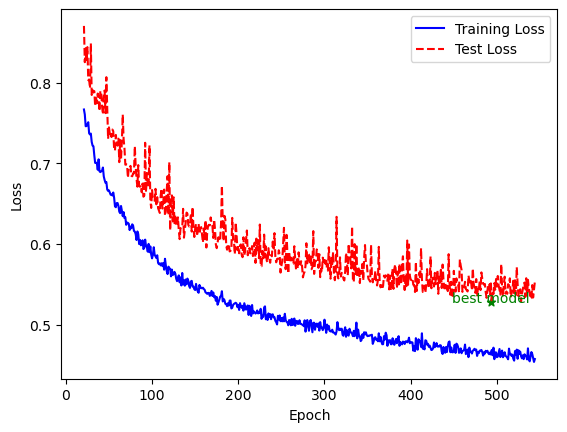

In [4]:
zoomin = 20
zoomout = 544
plotTraining(lossTrainArr, lossTestArr, LrCArr, bestLoss, zoomin, zoomout)

In [2]:
damaged_img_path = 'testdataset/damaged_image' 
lidar_path = 'testdataset/lidar_tensor/sparse'

label_path = 'testdataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)


In [3]:
# create testdataset

damaged_img_path = 'testdataset/damaged_image' 

if lidar_mode == 'sparse':
    lidar_path = 'testdataset/lidar_tensor/sparse'
else:
    lidar_path = 'testdataset/lidar_tensor/dense'

label_path = 'testdataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# load model
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.encoder = removal_layer

channelAdjust = EncoderFusion()

test_model_best = TwoEncoderOneDecoder(encoder_img, encoder_lidar, decoder, channelAdjust)
# for name, value in test_model_best.named_parameters():
#     print(name)

# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))

if lidar_mode == 'sparse':
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/6_channeladjust_sparse_best_model_best_model_600_32_20230522_154333.pth')
)
else:
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/6_channeladjust_dense_best_model_best_model_600_32_20230522_212511.pth')
)
# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()





TwoEncoderOneDecoder(
  (encoder1): SimpleAutoencoder(
    (encoder): Encoder(
      (downconv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (downconv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (encoderBlock1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (encoderBlock2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (decoder): Sequent

In [4]:
dataiter = iter(new_testloader)
num_iterations = 10  # Change this to the desired number of iterations

criterion = nn.MSELoss()
criterion.to(device)

for _ in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)
    output = test_model_best(damaged_img, lidar)


    batch_size = 32
    count = 0

    for j in range (batch_size):
        img1 = label[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)

0.507
0.527
0.567
1.248
0.925
0.602
0.256
0.224
0.369
0.449


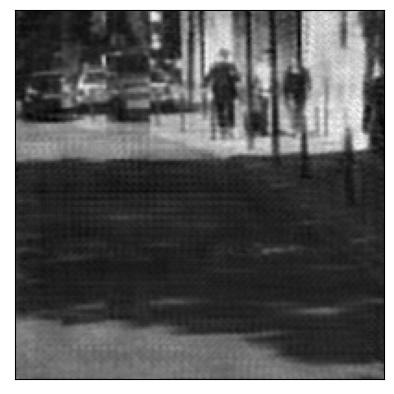

In [5]:
dataiter = iter(new_testloader)
num_iterations = 10

for j in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)
    output = test_model_best(damaged_img, lidar)
    
    for i in range(32):
        img1 = label[i]
        img4 = output[i].detach().numpy()
        img4 = img4.transpose(1, 2, 0)
        name = '%02d' %i

        plt.xticks([])
        plt.yticks([])
        plt.imshow(img4, cmap='gray')
        # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        # plt.margins(0,0)

        plt.savefig('fig_save/Fusion 3/{}_{:02}.png'.format(j,i),bbox_inches = 'tight',transparent = True)

In [ ]:
-------------------------------------------------------------------

In [2]:
# create testdataset
damage_severity = '3'
damaged_img_path = 'deepEmsemblesDataset/Salt/damaged_image_{}'.format(damage_severity) 


lidar_path = 'deepEmsemblesDataset/lidar_tensor'



label_path = 'deepEmsemblesDataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)


# load model
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.encoder = removal_layer

channelAdjust = EncoderFusion()

test_model_best = TwoEncoderOneDecoder(encoder_img, encoder_lidar, decoder, channelAdjust)
# for name, value in test_model_best.named_parameters():
#     print(name)

# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))

if lidar_mode == 'sparse':
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/6_channeladjust_sparse_best_model_best_model_600_32_20230522_154333.pth')
)
else:
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/6_channeladjust_dense_best_model_best_model_600_32_20230522_212511.pth')
)
# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()





TwoEncoderOneDecoder(
  (encoder1): SimpleAutoencoder(
    (encoder): Encoder(
      (downconv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (downconv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (encoderBlock1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (encoderBlock2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (decoder): Sequent

In [3]:
dataiter = iter(new_testloader)
num_iterations = 1  # Change this to the desired number of iterations

criterion = nn.MSELoss()
criterion.to(device)

for _ in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)
    output = test_model_best(damaged_img, lidar)


    batch_size = 32
    count = 0

    for j in range (batch_size):
        img1 = label[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


5.482


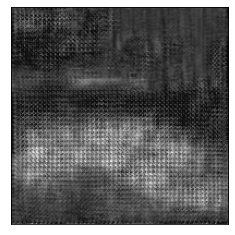

In [7]:
dataiter = iter(new_testloader)
num_iterations = 1

for j in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)
    output = test_model_best(damaged_img, lidar)

    for i in range(32):
        img1 = label[i]
        img4 = output[i].detach().numpy()
        img4 = img4.transpose(1, 2, 0)
        name = '%02d' %i

        plt.xticks([])
        plt.yticks([])
        plt.imshow(img4, cmap='gray')
        # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        # plt.margins(0,0)

        plt.savefig('fig_save/Fusion 3_new/{}_{:02}.png'.format(j,i),bbox_inches = 'tight',transparent = True)

In [8]:
dataiter = iter(new_testloader)
label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter)
# label, damaged_img, lidar = next(dataiter) # new damage




output = test_model_best(damaged_img, lidar)

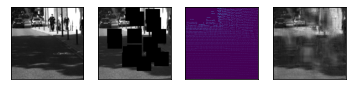

In [9]:
##################################################
# visualize one batch of the validation images #
##################################################
# test_model.to(device)


removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.encoder = removal_layer

channelAdjust = EncoderFusion()

test_model_best = TwoEncoderOneDecoder(encoder_img, encoder_lidar, decoder, channelAdjust)
# for name, value in test_model_best.named_parameters():
#     print(name)

if lidar_mode == 'sparse':
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/6_channeladjust_sparse_best_model_best_model_600_32_20230522_154333.pth')
)
else:
    test_model_best.load_state_dict(
    torch.load('model_save/fusion/3_dense_best_model_600_32_20230522_072759.pth')
)

# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()


# # obtain one batch of test images
# dataiter = iter(new_testloader)

# # dataiter = iter(valloader)

# label, damaged_img, lidar = next(dataiter)

# get sample outputs
output = test_model_best(damaged_img, lidar)

# prep images for display
# i = 31
for i in range(32):

    img1 = label[i].numpy()
    img1 = img1.transpose(1, 2, 0)
    img2 = damaged_img[i].numpy()
    img2 = img2.transpose(1, 2, 0)
    img3 = lidar[i].detach().numpy()
    img3 = img3.transpose(1, 2, 0)
    img4 = output[i].detach().numpy()
    img4 = img4.transpose(1, 2, 0)


    ax = plt.subplot(1, 4, 1)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('label')
    plt.imshow(img1,cmap='gray')

    ax = plt.subplot(1, 4, 2)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('damaged image')
    plt.imshow(img2,cmap='gray')

    ax = plt.subplot(1, 4, 3)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('lidar')
    plt.imshow(img3)

    ax = plt.subplot(1, 4, 4)
    plt.xticks([])
    plt.yticks([])
    #  ax.set_title('reconstructed image')
    plt.imshow(img4, cmap='gray')

    plt.savefig('fig_save/{}.png'.format(i))
    
plt.show()

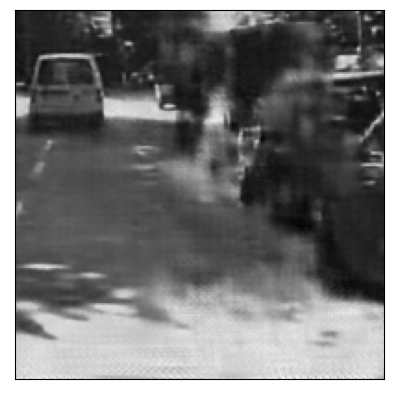

In [8]:
import cv2
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt


toPIL = transforms.ToPILImage()

# # prep images for display
# for i in range(32):
#     img1 = label[i]
#     img2 = damaged_img[i]
#     img3 = lidar[i]
#     img4 = output[i]
#     # print(img1.shape, img3.shape)
#     # print(type(img1),type(img3))
#     # im1 = toPIL(img1)
#     im4 = toPIL(img4)
#     im3 = toPIL(img3)
#     name = '%02d' %i

#     # im1.save('RecosntructedImages/ori_img/{}.png'.format(name))
#     # im2.save('RecosntructedImages/masked_img/{}.png'.format(name))
#     # im4.save('output_save/5_main_fusion_3_dense/A/{}.png'.format(name))
#     im3.save('output_save/lidar_sparse_testing/{}.png'.format(name))

    
import numpy as np
import cv2

for i in range(32):
    if i ==13:
        img1 = label[i].numpy()
        img1 = img1.transpose(1, 2, 0)
        img2 = damaged_img[i].numpy()
        img2 = img2.transpose(1, 2, 0)
        img3 = lidar[i].detach().numpy()
        img3 = img3.transpose(1, 2, 0)
        img4 = output[i].detach().numpy()
        img4 = img4.transpose(1, 2, 0)

        name = '%02d' %i
        filepath = 'output_save/test/{}.png'.format(name)

        # 调用函数将灰度图像保存为RGB图像的PNG
        # cv2.imwrite(filepath, img4)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img4, cmap='gray')
        plt.savefig(filepath)
        plt.show()
    

In [3]:
# MSE for all damages
criterion = nn.MSELoss()
criterion.to(device)

for i, batch in enumerate(new_testloader):# i -->index of batch
    count = 0
    for j in range (batch_size):
        img1 = label[i]
        img3 = output[i]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)

0.765
0.324
0.806
0.69
0.321
1.012
0.209
0.6


In [6]:
# # regional mse

# batch_size = 32

# def create_mask(image_shape, block_size, num_blocks):
#     mask = np.ones(image_shape, dtype=np.float32) 
#     block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
#     np.random.seed(6)

#     for _ in range(num_blocks):
#         top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
#         bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
#         mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        
#     return mask


# block_size = 0.2  # 方块大小为原图大小的百分比
# num_blocks = 16  # 方块数量

# count = 0

# for j in range(label.size(0)):
#     ori_img_np = label[j][0].detach().numpy()
#     output_np = output[j][0].detach().numpy()
#     mask = create_mask(ori_img_np.shape[:2], block_size, num_blocks)
#     local_mse = np.mean(np.square(output_np - ori_img_np) * mask)
#     count = count+local_mse
# local_mse = round(count/batch_size, 6)

# # baseline
# for j in range(label.size(0)):
#     ori_img_np = label[j][0].detach().numpy()
#     output_np = output[j][0].detach().numpy()
#     mask = create_mask(ori_img_np.shape[:2], block_size, num_blocks)
#     local_mse = np.mean(np.square(output_np - ori_img_np) * mask)
#     count = count+local_mse
# local_mse = round(count/batch_size, 6)

# print(local_mse)

0.008371


In [18]:
# import numpy as np
# batchsize = 32
# def mse(image1, image2, mask):
#     masked_image1 = image1 * mask
#     masked_image2 = image2 * mask
#     diff = masked_image1 - masked_image2
#     mse_value = np.mean(np.square(diff))
#     return mse_value

# def create_mask(image_shape, block_size, num_blocks):
#     mask = np.ones(image_shape, dtype=np.float32) 
#     block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
#     np.random.seed(6)

#     for _ in range(num_blocks):
#         top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
#         bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
#         mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        
#     return mask

# count = 0
# shape = (200, 200)
# block_size = 0.2
# num_blocks =16
# mask = create_mask(shape, block_size, num_blocks)

# for j in range(batchsize):
#     original_image = label[j][0].detach().numpy()
#     output_image = output[j][0].detach().numpy()
#     mask_mse = mse(output_image, original_image, mask)
#     count += mask_mse
     
# print(count/batchsize)

0.004185696510830894


In [10]:
import cv2
import os
import numpy

masked_region_list = []
original_image_list = []

image_path = 'testdataset/ori_image'
images = sorted(glob.glob(image_path + '/*'))[0:32]
damage_label = 'A'

def create_mask(image_shape, block_size, num_blocks):
    mask = np.ones(image_shape, dtype=np.float32) 
    block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
    np.random.seed(6)
    masked_region = []

    for _ in range(num_blocks):
        top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
        bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
        mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        masked_region.append((top_left, bottom_right))
        
    return mask, masked_region


for i in range(len(images)):
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ori_img_name = os.path.basename(images[i])

    block_size = 0.2  # 方块大小为原图大小的百分比
    num_blocks = 16  # 方块数量
    mask, masked_region = create_mask(image.shape[:2], block_size, num_blocks)
    masked_region_list.append(masked_region)
    original_image_list.append(image)
    damaged_img1 = image * mask
    # cv2.imwrite(f'testdataset/damaged_image/{damage_label}_{ori_img_name}', damaged_img1)

regional_mse_list = []

for i in range(len(images)):
    original_image = original_image_list[i]
    masked_region = masked_region_list[i]
    original_image = (original_image-np.min(original_image))/(np.max(original_image)-np.min(original_image))
    

    
    # Obtain the output reconstructed image
    output_image = output[i][0].detach().numpy()  # Replace this with the code to get the output image from your image reconstruction network
    # output_image = (output_image-np.min(output_image))/(np.max(output_image)-np.min(output_image))
    
    mse = 0
    num_pixels = 0

    for region in masked_region:
        top_left, bottom_right = region
        original_pixels = original_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        output_pixels = output_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        diff = original_pixels.astype(np.float32) - output_pixels.astype(np.float32)
        mse += np.sum(diff ** 2)
        num_pixels += original_pixels.size

    mse /= num_pixels
    regional_mse_list.append(mse)

print(np.mean(regional_mse_list))

0.030955639440508095


In [11]:
# SSIM

import torch
from skimage.metrics import structural_similarity as ssim
import glob


metric_value_list = []
batch_size = 32


for i, batch in enumerate(new_testloader):
    label, damaged_img, lidar = batch
    count = 0
    for j in range(label.size(0)):
        ori_img_np = label[j][0].detach().cpu().numpy()
        output_np = output[j][0].detach().cpu().numpy()
        ssim_img, diff = ssim(ori_img_np, output_np, full=True, data_range=1.0)
        count = count + ssim_img
    ssim_img = round(count / label.size(0), 3)
    print(ssim_img)
#     metric_value_list.append(ssim_img)

# print(metric_value_list)

0.498
0.183
0.173
0.162
0.163
0.168
0.169
0.173


In [12]:
# LLIPS metrics

import lpips

loss_fn = lpips.LPIPS(net='alex')


for i, batch in enumerate(new_testloader):  # i -->index of batch
    label, damaged_img, lidar = batch
    count = 0
    for j in range(label.size(0)):
        # ori_img_np = ori_img[j][0].detach().numpy()
        # output_np = output[j][0].detach().numpy()
        lpips_img = loss_fn.forward(label, output)
        sum_result = (torch.sum(lpips_img)).item()
        count = count+sum_result
        # count = count.item()
    lpips_img = round(count/label.size(0),3)
    print(lpips_img)
#     metric_value_list.append(lpips_img)

# print(f'scuccess: {metric_value_list}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
12.396
17.63
17.751
18.231
17.825


KeyboardInterrupt: 

In [ ]:
# edge detection metric

output_images_folder = 'output_images'  # Specify the folder to save the output images

for i in range(len(images)):
    original_image = original_image_list[i]
    masked_region = masked_region_list[i]

    # Obtain the output reconstructed image
    output_image = ...  # Replace this with the code to get the output image from your image reconstruction network

    for j, region in enumerate(masked_region):
        top_left, bottom_right = region
        region_name = f'region_{j+1}.png'
        region_image = output_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        region_path = os.path.join(output_images_folder, region_name)
        cv2.imwrite(region_path, region_image)
